In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp=spacy.load('en_core_web_sm')
from textblob import TextBlob, Word, Blobber

from sb_utils import save_file


from surprise import accuracy, Dataset, SVD, NormalPredictor, BaselineOnly
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut, ShuffleSplit 
from surprise.model_selection import RandomizedSearchCV,GridSearchCV
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold

from sklearn.model_selection import train_test_split as tts1
import datetime
import math

In [2]:
wine_df = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/Capstone project 3/data/wine_df_S.csv')

In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   RatingID                                150000 non-null  int64  
 1   UserID                                  150000 non-null  int64  
 2   WineID                                  150000 non-null  int64  
 3   Vintage                                 150000 non-null  object 
 4   Rating                                  150000 non-null  float64
 5   Date                                    150000 non-null  object 
 6   rating_mean                             150000 non-null  float64
 7   rater_count                             150000 non-null  int64  
 8   rater_mean                              150000 non-null  float64
 9   WineName                                150000 non-null  object 
 10  Type                                    1500

Since our recommender system will be based on user ratings of wine, let’s start by parsing out the user id, wine id and rating.

In [4]:
rec_base=wine_df[['UserID', 'WineID','Rating']]

In [5]:
rec_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  150000 non-null  int64  
 1   WineID  150000 non-null  int64  
 2   Rating  150000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.4 MB


Next I will create the surprise data set to cross-validate our models on as well as create an anti-set to run predictions on later.

In [6]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rec_base[['UserID', 'WineID', 'Rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()

I will start with a Normal Predictor model to examine a baseline RMSE for our dataset.

### Normal Predictor Model

In [7]:
algo = NormalPredictor()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9055  0.9019  0.9085  0.9053  0.0027  
MAE (testset)     0.7171  0.7152  0.7219  0.7181  0.0028  
Fit time          0.17    0.19    0.19    0.18    0.01    
Test time         0.56    0.57    0.34    0.49    0.11    


{'test_rmse': array([0.90546002, 0.90189442, 0.90846457]),
 'test_mae': array([0.71714124, 0.7151529 , 0.72189367]),
 'fit_time': (0.16591095924377441, 0.19288969039916992, 0.18789148330688477),
 'test_time': (0.5636751651763916, 0.5672638416290283, 0.33780598640441895)}

As expected it looks like our mean RMSE (0.906) is fairly high for a rating scale of 1-5. Let’s try out another model.

### SVD Model

In [8]:
algo2 = SVD()
cross_validate(algo2, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4897  0.4896  0.4883  0.4892  0.0006  
MAE (testset)     0.3593  0.3593  0.3594  0.3593  0.0000  
Fit time          1.42    1.59    2.40    1.80    0.43    
Test time         0.61    0.71    0.50    0.61    0.09    


{'test_rmse': array([0.48972791, 0.48958801, 0.48829018]),
 'test_mae': array([0.35932707, 0.35931971, 0.35936035]),
 'fit_time': (1.4221687316894531, 1.58656907081604, 2.398963212966919),
 'test_time': (0.6126642227172852, 0.7121484279632568, 0.4967479705810547)}

The SVD model gives us a much better mean RMSE of 0.488. Next I will test out some of the KNN models.

### KNN With Means Model

In [9]:
algo3 = KNNWithMeans()
cross_validate(algo3, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5242  0.5275  0.5215  0.5244  0.0025  
MAE (testset)     0.3891  0.3912  0.3882  0.3895  0.0013  
Fit time          4.64    5.01    4.72    4.79    0.16    
Test time         16.78   17.16   15.35   16.43   0.78    


{'test_rmse': array([0.52420318, 0.52752245, 0.52152346]),
 'test_mae': array([0.38906131, 0.39119688, 0.38819892]),
 'fit_time': (4.6422765254974365, 5.011636734008789, 4.721883773803711),
 'test_time': (16.7757830619812, 17.15996289253235, 15.353219985961914)}

The KNNWithMeans model has a higher mean RMSE than the previous model. The test time is also much longer than the both of the previous models. 

### KNN Baseline Model

In [10]:
algo4 = KNNBaseline()
cross_validate(algo4, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4889  0.4890  0.4844  0.4874  0.0021  
MAE (testset)     0.3565  0.3581  0.3556  0.3567  0.0010  
Fit time          4.77    5.05    5.23    5.01    0.19    
Test time         17.26   17.88   17.95   17.70   0.31    


{'test_rmse': array([0.48885374, 0.48897857, 0.4844312 ]),
 'test_mae': array([0.35646568, 0.3580669 , 0.35559216]),
 'fit_time': (4.765731334686279, 5.045135736465454, 5.22603440284729),
 'test_time': (17.257729291915894, 17.884800672531128, 17.953495740890503)}

The KNNBaseline model seems to have the best mean RMSE at 0.486. It also has the longest mean fit and test time of all of our models. 

From the results outputted from testing different models on our data, I think it would be wise to move forward with fine tuning and applying both the KNNBaseline model as well as our SVD model. Even though the KNNBaseline model technically has the best mean RMSE, The SVD model has an RMSE that is very close and also would save a lot of test and fit time. I think it would be worth comparing the predictions for both models to find out if we can save time in the long run.

First let’s run a grid search for the best hyperparameters for our KNNBaseline Model.

In [11]:
#Gridsearch for KNNBaseline

In [12]:
param_gridKNNB = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gsKNNB = GridSearchCV(KNNBaseline, param_gridKNNB, measures=['rmse'], cv=3)

gsKNNB.fit(data)

print('Best RMSE:', gsKNNB.best_score['rmse'], gsKNNB.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

It looks like the best parameters for this model are as follows:
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


Now let’s find the best parameters for the SVD model.

In [13]:
#GridSearch for SVD

In [14]:
param_grid = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gs_SVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs_SVD.fit(data)

print('Best RMSE:', gs_SVD.best_score['rmse'], gs_SVD.best_params['rmse'])

Best RMSE: 0.5024278113573212 {'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


The best parameters for the SVD model are as follows:
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}

Next I will create the traintest split for the data.

In [15]:
#update to surprise traintest set to make predictions
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

To apply the model and get predictions, I will create a dataframe that will display the userID, wineID, the actual rating and the predicted rating from our model. I will also include an error column that displays the difference between the actual rating and the predicted rating.

In [16]:
#KNNBaseline
predictions = KNNBaseline(bsl_options=gsKNNB.best_params['rmse']).fit(trainset).test(testset)
KNN_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
KNN_Predictions.drop(['details'], axis=1, inplace=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
#SVD
predictions = SVD(n_epochs=15, lr_all=0.005, reg_all=0.4).fit(trainset).test(testset)
SVD_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
SVD_Predictions.drop(['details'], axis=1, inplace=True)

In [18]:
#knnbaseline
KNN_Predictions['Error'] = abs(KNN_Predictions['Real_Rating'] - KNN_Predictions['Estimated_Rating'])

In [19]:
#svd
SVD_Predictions['Error'] = abs(SVD_Predictions['Real_Rating'] - SVD_Predictions['Estimated_Rating'])

In [20]:
KNN_Predictions.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Error
0,1971360,111475,4.0,4.297177,0.297177
1,1358888,193487,3.0,3.284433,0.284433
2,1222064,155623,3.0,2.885143,0.114857
3,1095942,113730,4.5,4.218465,0.281535
4,1006401,111434,4.0,4.336163,0.336163


Let’s examine the relationship between the real ratings and the estimated ratings.

I want to examine how many estimated ratings have a low error.

In [21]:
low_error=KNN_Predictions[KNN_Predictions['Error'] < .1]

In [22]:
low_error.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275 entries, 5 to 37492
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UserID            7275 non-null   int64  
 1   WineID            7275 non-null   int64  
 2   Real_Rating       7275 non-null   float64
 3   Estimated_Rating  7275 non-null   float64
 4   Error             7275 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 341.0 KB


In [23]:
low_error.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Error
5,1215266,111429,4.0,4.067975,0.067975
6,1210984,135885,4.0,3.967138,0.032862
7,1064790,113344,4.0,4.068471,0.068471
10,1387564,167530,3.5,3.484070,0.015930
11,1104552,183463,3.5,3.526267,0.026267


This model produced 7278 estimated ratings out of 150,000 with errors less than 0.1. Let’s take a look at the distribution of this subset of real ratings.

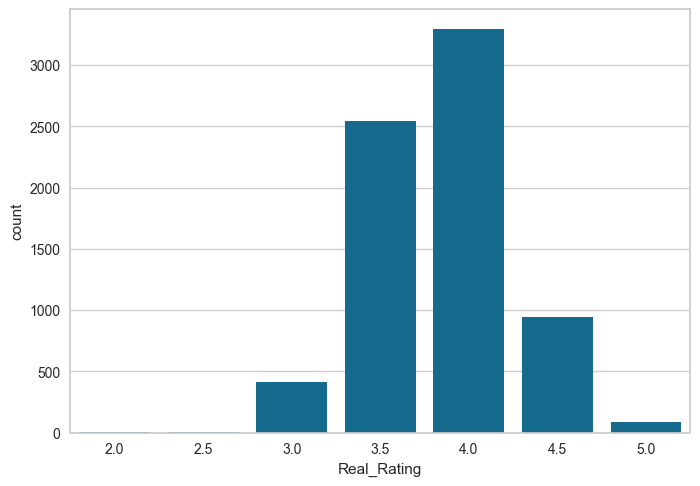

In [24]:
sns.countplot(data=low_error, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


It looks like this model is best at predicting ratings of 4.0. It Is also worth noting that this rating distribution is similar to the total data set.

Let’s take a look at our predictions with the SVD model.

In [25]:
SVD_Predictions.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Error
0,1971360,111475,4.0,4.231913,0.231913
1,1358888,193487,3.0,3.446532,0.446532
2,1222064,155623,3.0,3.076992,0.076992
3,1095942,113730,4.5,4.213787,0.286213
4,1006401,111434,4.0,4.292957,0.292957


Let’s take a look at how many ratings we get with a low error.

In [26]:
low_error2=SVD_Predictions[SVD_Predictions['Error'] < .1]

In [27]:
low_error2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7070 entries, 2 to 37496
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UserID            7070 non-null   int64  
 1   WineID            7070 non-null   int64  
 2   Real_Rating       7070 non-null   float64
 3   Estimated_Rating  7070 non-null   float64
 4   Error             7070 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 331.4 KB


In [28]:
low_error2.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Error
2,1222064,155623,3.0,3.076992,0.076992
5,1215266,111429,4.0,4.086092,0.086092
7,1064790,113344,4.0,3.961153,0.038847
10,1387564,167530,3.5,3.522494,0.022494
12,1765460,111590,4.0,4.033853,0.033853


The number of predictions in this data subset is 7070. This is similar to but less than the number of low error predictions from the KNN baseline model. Let’s take a look at the distribution of this subset as well.

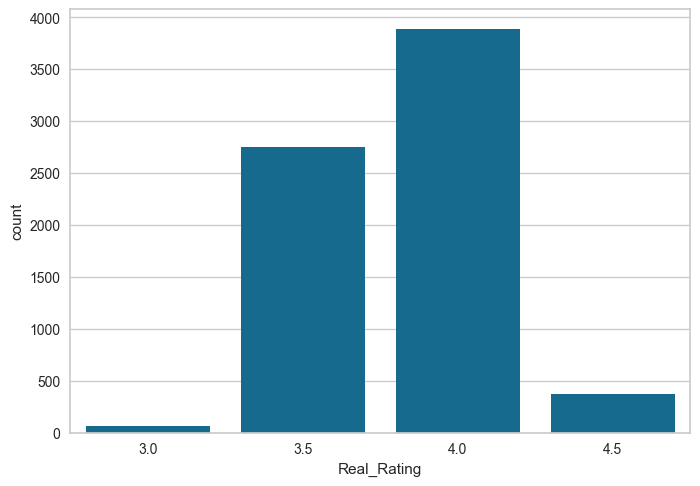

In [29]:
sns.countplot(data=low_error2, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


The rating distribution for this model is very similar to the KNNBaseline model with the top represented rating being 4.0.

Let’s compare the RMSE for the different models on our traintest set.

In [30]:
rmseK = np.sqrt(np.mean((KNN_Predictions['Error']) ** 2))
rmseS = np.sqrt(np.mean((SVD_Predictions['Error']) ** 2))


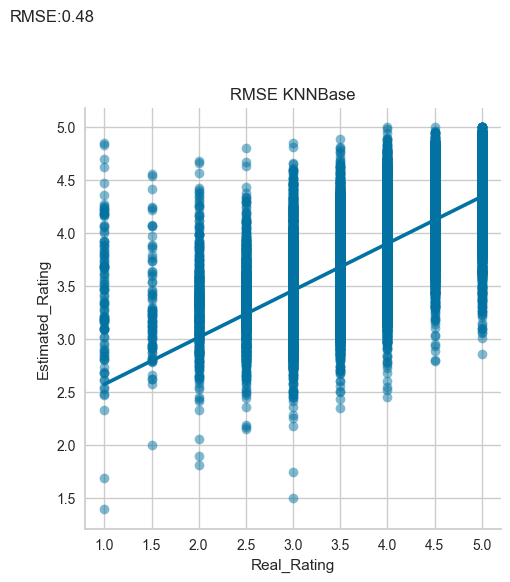

In [31]:
sns.lmplot(x='Real_Rating', y='Estimated_Rating', data=KNN_Predictions, scatter_kws={'alpha': 0.5})
plt.text(x=0, y=6, s='RMSE:{:.2f}'.format(rmseK), fontsize=12)
plt.title('RMSE KNNBase')
plt.show()

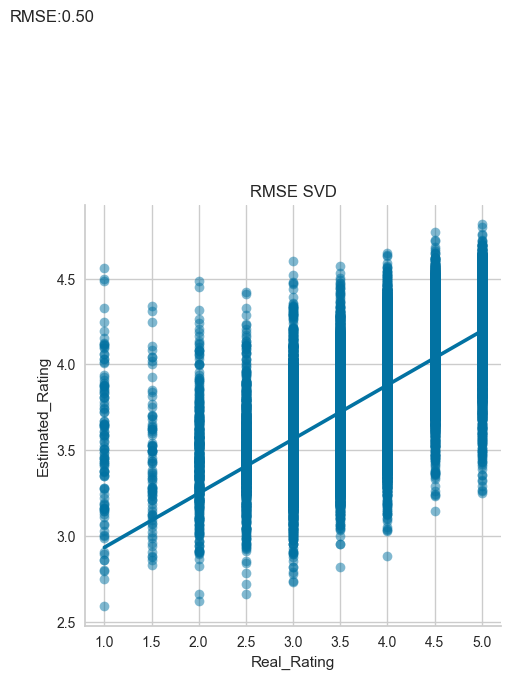

In [32]:
sns.lmplot(x='Real_Rating', y='Estimated_Rating',data=SVD_Predictions, scatter_kws={'alpha': 0.5})
plt.text(x=0, y=6, s='RMSE:{:.2f}'.format(rmseS), fontsize=12)
plt.title('RMSE SVD')
plt.show()

The RMSE for the KNN baseline model is pretty much the same as our initial cross validation mean. The SVD model is a bit higher than our initial cross validation mean.

### Conclusions

After using each model to create predictions it looks like the KNNBaseline model produces better results than the SVD model. The KNN Baseline model has a better RMSE and has more estimated ratings with low errors than the SVD mode. It seems that the KNN Baseline would be the better model to use to increase the chance of predicting ratings more accurately. Considering that the difference in outcomes between the two models is small and the time difference for applying the models is fairly large, it may be worth it to our stake holders to use the SVD model. A choice would have to be made here on whether accuracy or resource usage is the most important factor.